# _Ordinary least squares_

Hier passen we de _closed form_ oplossing toe op de gesimuleerde koffieshop 

$$
\hat{\pmb{b}} = (\pmb{X}^T\pmb{X})^{-1}\pmb{X}^T\pmb{y}
$$

Voor ons model met intercept en één predictor wordt de design matrix $\pmb{X}$:

$$
\pmb{X} = \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_m \end{bmatrix}
$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ml_courses.sim.monte_carlo_tips import MonteCarloTipsSimulation

In [2]:
# Data generation
sim = MonteCarloTipsSimulation(seed=42)

In [3]:
# Feature/design matrix X
n = len(sim.order_totals)
X = np.column_stack([np.ones(n), sim.order_totals])

In [4]:
# Closed form calculation

# Step 1: X^T X
XTX = X.T @ X

# Step 2: (X^T X)^(-1)
XTX_inv = np.linalg.inv(XTX)

# Step 3: X^T y
XTy = X.T @ sim.observed_tips

# Step 4: Final solution
beta_hat = XTX_inv @ XTy
b1_hat, b2_hat = beta_hat

print("\nEstimated parameters:")
print(f"b1_hat (intercept) = ${b1_hat:.3f}")
print(f"b2_hat (slope) = {b2_hat:.4f}")
print("\nTrue parameters:")
print(f"b1_true = ${sim.true_b1:.3f}")
print(f"b2_true = {sim.true_b2:.4f}")


Estimated parameters:
b1_hat (intercept) = $0.559
b2_hat (slope) = 0.1426

True parameters:
b1_true = $0.500
b2_true = 0.1500


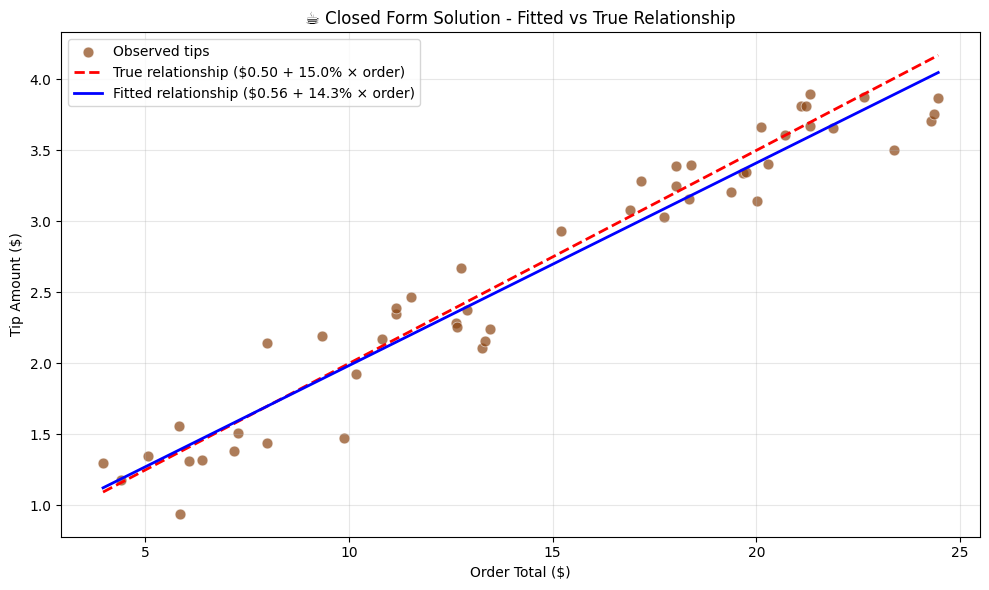

In [5]:
# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(
    sim.order_totals,
    sim.observed_tips,
    alpha=0.7,
    color="saddlebrown",
    s=60,
    edgecolor="white",
    linewidth=0.5,
    label="Observed tips",
)

# True relationship
plt.plot(
    sim.order_totals,
    sim.true_tips,
    "r--",
    linewidth=2,
    label=f"True relationship (${sim.true_b1:.2f} + {sim.true_b2:.1%} × order)",
)

# Estimated relationship
predicted_tips = b1_hat + b2_hat * sim.order_totals
plt.plot(
    sim.order_totals,
    predicted_tips,
    "b-",
    linewidth=2,
    label=f"Fitted relationship (${b1_hat:.2f} + {b2_hat:.1%} × order)",
)

plt.xlabel("Order Total ($)")
plt.ylabel("Tip Amount ($)")
plt.title("☕ Closed Form Solution - Fitted vs True Relationship")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Voordeel
Optimale parameterwaarden op basis van SSE _loss_ via één _batch_ berekening.

## Nadeel
De _ordinary least squares_ oplossing heeft een belangrijke beperking: **we moeten de matrix $(\pmb{X}^T\pmb{X})^{-1}$ kunnen berekenen**. Dit vereist dat $\pmb{X}^T\pmb{X}$ **_volledig van rang is_** is.

$\pmb{X}^T\pmb{X}$ is niet inverteerbaar (**"singulier"**) bij:

- Perfecte _multicollineariteit_: Wanneer twee of meerdere features perfecte lineaire combinaties van elkaar zijn (of identiek aan elkaar).
- Meer features dan observaties: Bij $M < N$ in $X$, is $\pmb{X}^T\pmb{X}$ gegarandeerd singulier. De matrix $\pmb{X}^T\pmb{X}$ zal $N \times N$ zijn maar een rang hebben van maximaal $M < N$.  
  

Gevolgen:
- Het systeem heeft ofwel geen unieke oplossing of oneindig veel oplossingen
- Matrix inversie faalt numeriek
- De parameters $\pmb{b}$ zijn niet uniek identificeerbaar  
  
Zelf wanneer _multicollineariteit_ niet perfect, maar wel substantieel is (en $\pmb{X}^T\pmb{X}$ inverteerbaar), is er een risico dat kleine veranderingen in de data tot grote verschillen in de parameterschattingen leiden en de _onzekerheid_ over parameterschattingen zeer groot is.
  
Singulariteit of het risico op onstabiliteit kan gediagnosticeerd worden aan de hand van het zogeheten [_conditienummer_](https://en.wikipedia.org/wiki/Condition_number).
  
Oplossingen:
- **Regularisatie** (Ridge, Lasso): Het toevoegen van een _penalty_ zoals $\lambda\pmb{I}$ (met $\lambda\geq0$) maakt $\pmb{X}^T\pmb{X} + \lambda\pmb{I}$ inverteerbaar.
- Feature selectie: Verwijderen van redundante of collineaire features.
- Dimensionaliteitsreductie: PCA of andere technieken.
- Pseudo-inverse: Het gebruik van de Moore-Penrose pseudo-inverse.
- Iteratieve methoden: **Gradient descent** vereist geen matrix inversie.  
  
Dit is waarom _iteratieve_ gradient-gebaseerde optimalisatiemethoden vaak de voorkeur genieten in moderne machine learning, vooral voor hoogdimensionale problemen.

Hieronder geven ze een voorbeeld van singulariteit door $M < N$.

In [6]:
rng = np.random.default_rng(123)
n_small = 3  # Only 3 observations
p = 4  # But we want to estimate 4 features

# Generate dataset
X_small = rng.standard_normal((n_small, p))
y_small = rng.standard_normal(n_small)

print(f"X_small shape: {X_small.shape}")
print(f"y_small shape: {y_small.shape}")

X_small shape: (3, 4)
y_small shape: (3,)


In [7]:
# Try closed form solution
XTX_small = X_small.T @ X_small

rank = np.linalg.matrix_rank(XTX_small)
print(f"Rank of X^T X: {rank} (should be {p})")
condition_number = np.linalg.cond(XTX_small)
print(f"Condition number of X^T X: {condition_number:.2e}")

try:
    XTX_inv_small = np.linalg.inv(XTX_small)
    beta_small = XTX_inv_small @ X_small.T @ y_small
    print(f"Estimated parameters: {beta_small}")

except Exception as e:
    print(f"❌ Error in matrix inversion: {e}")

Rank of X^T X: 3 (should be 4)
Condition number of X^T X: inf
Estimated parameters: [ 8.84011175 29.07666781 -5.22136417 -1.63398927]


Hoewel NumPy een inverse genereert, geeft het oneindige conditienummer aan dat $\pmb{X}^T\pmb{X}$ wel degelijk singulier is.
  
Hieronder illustreren we het probleem bij multicollineariteit

In [8]:
n = 10

# Feature 1: random numbers
x1 = rng.random(n)

# Feature 2: perfect linear combination of feature 1
x2 = 2 * x1 + 0.01  # Perfectly correlated

# Feature 3: constant (no information)
x3 = np.ones(n)

# Build design matrix with multicollinearity
X_multi = np.column_stack([x1, x2, x3])
y_multi = x1 + rng.random(n) * 0.1  # y depends mainly on x1

print(f"Correlation between x1 and x2: {np.corrcoef(x1, x2)[0, 1]:.6f}")

Correlation between x1 and x2: 1.000000


In [9]:
XTX_multi = X_multi.T @ X_multi

rank = np.linalg.matrix_rank(XTX_multi)
print(f"Rank of X^T X: {rank} (should be {p})")
condition_number = np.linalg.cond(XTX_multi)
print(f"Condition number of X^T X: {condition_number:.2e}")

try:
    XTX_inv_multi = np.linalg.inv(XTX_multi)
    beta_multi = XTX_inv_multi @ X_multi.T @ y_multi
    print(f"Estimated parameters: {beta_multi}")

except Exception as e:
    print(f"❌ Error in matrix inversion: {e}")

Rank of X^T X: 2 (should be 4)
Condition number of X^T X: 1.40e+16
Estimated parameters: [-2.47669566  0.75823902  0.07479962]


In [10]:
X_multi[0, 0] += 0.001  # Slightly perturb one value


XTX_multi = X_multi.T @ X_multi

rank = np.linalg.matrix_rank(XTX_multi)
print(f"Rank of X^T X: {rank} (should be {p})")
condition_number = np.linalg.cond(XTX_multi)
print(f"Condition number of X^T X: {condition_number:.2e}")

try:
    XTX_inv_multi = np.linalg.inv(XTX_multi)
    beta_multi = XTX_inv_multi @ X_multi.T @ y_multi
    print(f"Estimated parameters: {beta_multi}")

except Exception as e:
    print(f"❌ Error in matrix inversion: {e}")

Rank of X^T X: 3 (should be 4)
Condition number of X^T X: 3.39e+07
Estimated parameters: [-64.90113349  32.93863669  -0.24796529]


We zien hier geen oneindige, maar wel zeer grote conditienummers. Bovendien zorgt een heel kleine aanpassing van de data voor een grote verschuiving in de schattingen.